 # Analysis of ISEF Project Abstracts Using Latent Dirichlet Allocation (LDA)

 ## 1. Introduction

 The Regeneron International Science and Engineering Fair (ISEF) is the world's largest pre-college scientific research event. Each year, it showcases innovative projects from young scientists and engineers across the globe. This notebook presents an in-depth analysis of ISEF project abstracts using Latent Dirichlet Allocation (LDA), a statistical model for discovering abstract topics in a collection of documents.



 Our analysis aims to:

 1. Uncover latent themes and trends in ISEF projects over time

 2. Identify patterns in research focus across different categories and countries

 3. Provide insights that could guide future participants and organizers



 LDA is particularly suitable for this task as it can identify underlying topics in a large corpus of text without prior labeling. By applying LDA to ISEF abstracts, we can reveal the thematic structure of student research projects and how these themes evolve over time.

 ## 2. Setup and Data Loading

 First, we'll import the necessary libraries and set up our environment.

In [49]:
# %%
import logging
import re
import warnings
from collections import Counter
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)

# Download necessary NLTK data
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

True

 Now, let's define a robust function to load and validate our data.

In [3]:
# %%
def load_and_validate_data(file_path: str) -> pd.DataFrame:
    """
    Load the ISEF project data from a CSV file and perform basic validation.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded and validated DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        required_columns = [
            "Year",
            "Project Title",
            "Category",
            "Fair Country",
            "Abstract",
        ]

        # Check for required columns
        missing_columns = set(required_columns) - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

        # Check for missing values
        missing_values = df[required_columns].isnull().sum()
        if missing_values.sum() > 0:
            logging.warning(f"Missing values detected:\n{missing_values}")

        # Basic data type validation
        if not pd.api.types.is_numeric_dtype(df["Year"]):
            raise TypeError("'Year' column should contain numeric values")

        # Ensure abstracts are strings
        df["Abstract"] = df["Abstract"].astype(str)

        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

 Let's load our data and display some basic information.

In [4]:
# %%
file_path = "../data/isef_projects.csv"
df = load_and_validate_data(file_path)

2024-07-23 02:58:04,231 - WARNING - Missing values detected:
Year                0
Project Title       0
Category         2049
Fair Country        0
Abstract            0
dtype: int64
2024-07-23 02:58:04,232 - INFO - Data loaded successfully. Shape: (14871, 10)


In [5]:
df.head()

,Year,Finalist Name(s),Project Title,Category,Fair Country,Fair State,Fair Province,Awards Won,Link,Abstract
0,2014,"Kitaoka, Robert",Dynamic Response of a Human Neck Replica to Ax...,Energy: Physical,United States of America,MN,NaN,NaN,https://abstracts.societyforscience.org/Home/F...,Purpose: A human neck replica was made to simu...
1,2014,"Swan, Boston",The Effect of Nutrient Solution Concentration ...,Physics and Astronomy,United States of America,UT,NaN,NaN,https://abstracts.societyforscience.org/Home/F...,The purpose of this experiment is to determine...
2,2014,"Ham, John",Do Air Root Pruning Pots Accelerate Success in...,Physics and Astronomy,United States of America,LA,NaN,NaN,https://abstracts.societyforscience.org/Home/F...,Organochlorine pesticides in agriculture are n...
3,2014,"Huh, Heeyong",Insect-repelling Plants & New Organic Pesticide,Environmental Engineering,United States of America,TX,NaN,NaN,https://abstracts.societyforscience.org/Home/F...,The purpose of my project was to determine whi...
4,2014,"Ince, Lucas",How Do Different Factors Affect the Accuracy o...,Earth and Environmental Sciences,United States of America,MN,NaN,NaN,https://abstracts.societyforscience.org/Home/F...,Studies comparing the mineral nutrition of hyd...


 ## 3. Exploratory Data Analysis (EDA)

 Let's start by analyzing the distribution of projects across years, categories, and countries.

In [6]:
# %%
def plot_project_distribution(
    df: pd.DataFrame,
    column: str,
    title: str,
    top_n: int = 10,
) -> None:
    """
    Plot the distribution of projects for a given column.

    Args:
        df (pd.DataFrame): The dataset
        column (str): The column to analyze
        title (str): The title for the plot
        top_n (int): Number of top categories to display (for categorical data)
    """
    plt.figure(figsize=(12, 6))
    if df[column].dtype == "object":
        top_categories = df[column].value_counts().nlargest(top_n)
        sns.barplot(x=top_categories.index, y=top_categories.values)
        plt.title(f"Top {top_n} {title}")
        plt.xticks(rotation=45, ha="right")
    else:
        sns.histplot(df[column], kde=True)
        plt.title(f"Distribution of {title}")
    plt.tight_layout()
    plt.show()

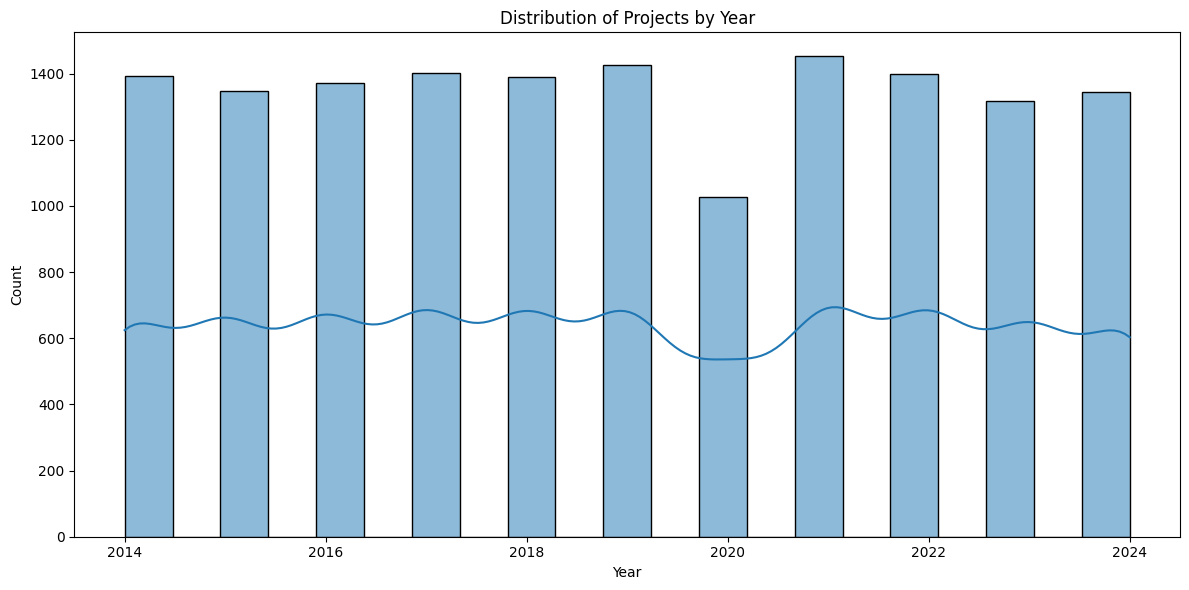

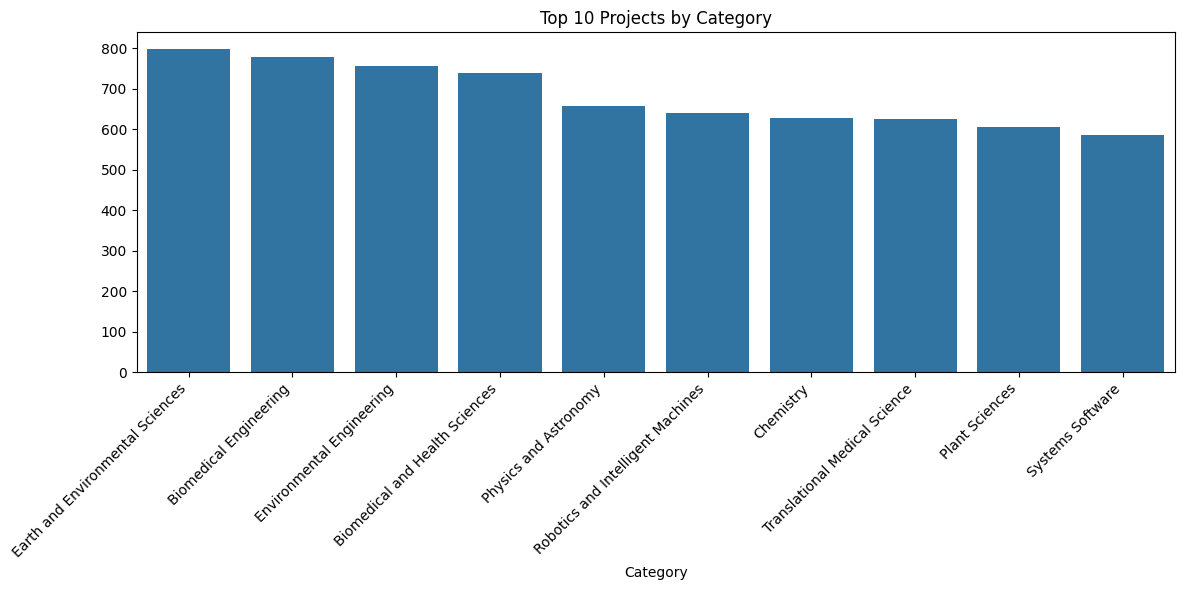

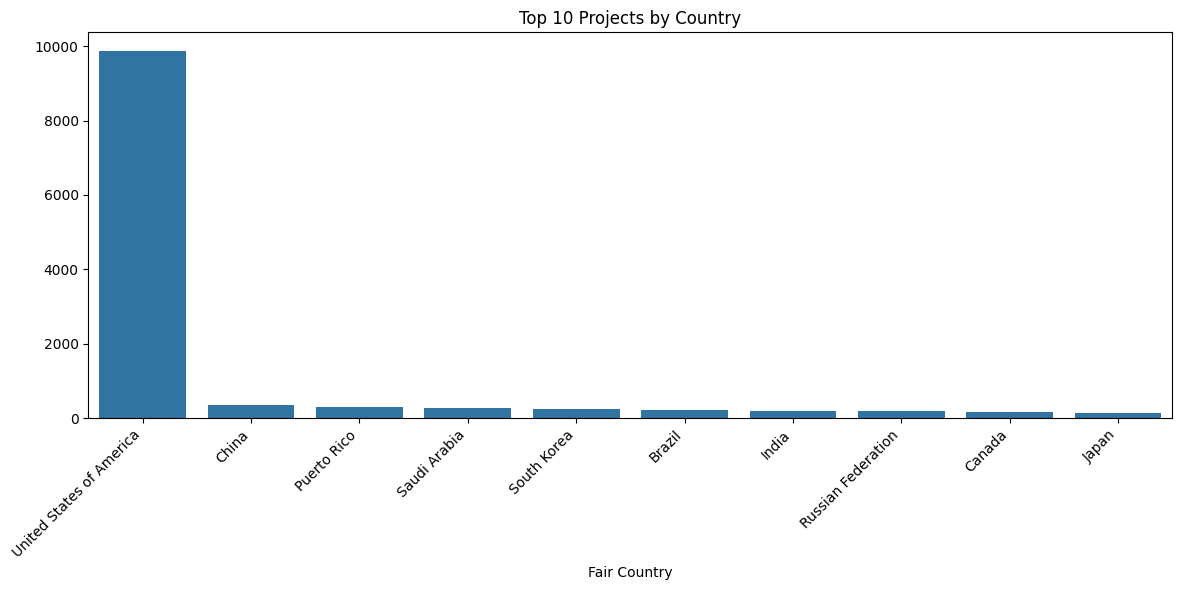

In [7]:
# %%
plot_project_distribution(df, "Year", "Projects by Year")
plot_project_distribution(df, "Category", "Projects by Category")
plot_project_distribution(df, "Fair Country", "Projects by Country")

 Now, let's analyze the abstract length and complexity.

In [8]:
# %%
def analyze_abstract_complexity(df: pd.DataFrame) -> None:
    """
    Analyze and visualize abstract length and complexity.

    Args:
        df (pd.DataFrame): The dataset containing abstracts
    """
    df["Abstract_Length"] = df["Abstract"].apply(len)
    df["Word_Count"] = df["Abstract"].apply(lambda x: len(x.split()))
    df["Avg_Word_Length"] = df["Abstract"].apply(
        lambda x: np.mean([len(word) for word in x.split()])
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.histplot(df["Abstract_Length"], kde=True, ax=axes[0])
    axes[0].set_title("Distribution of Abstract Length")
    axes[0].set_xlabel("Number of Characters")

    sns.histplot(df["Word_Count"], kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Word Count")
    axes[1].set_xlabel("Number of Words")

    sns.histplot(df["Avg_Word_Length"], kde=True, ax=axes[2])
    axes[2].set_title("Distribution of Average Word Length")
    axes[2].set_xlabel("Average Word Length")

    plt.tight_layout()
    plt.show()

    print(f"Median Abstract Length: {df['Abstract_Length'].median()} characters")
    print(f"Median Word Count: {df['Word_Count'].median()} words")
    print(
        f"Median Average Word Length: {df['Avg_Word_Length'].median():.2f} characters"
    )

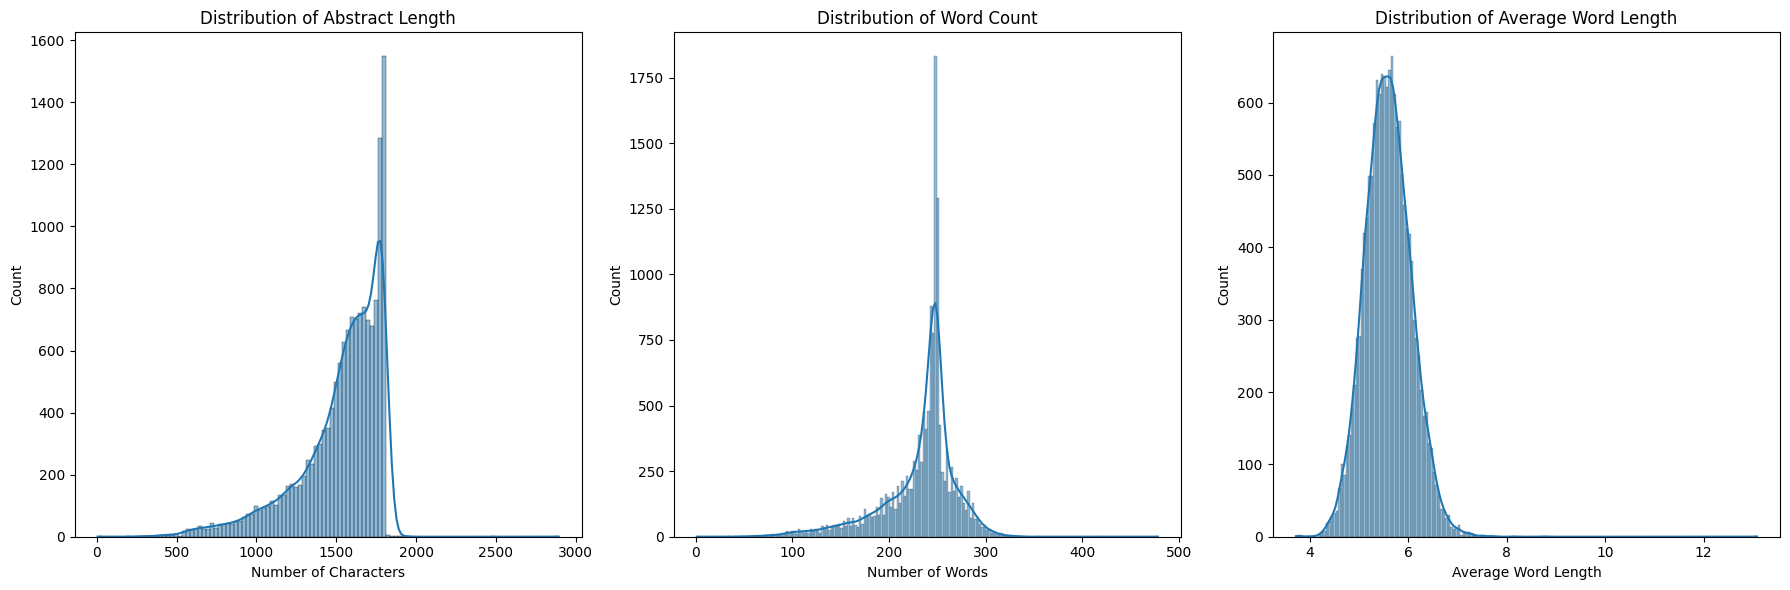

Median Abstract Length: 1602.0 characters
Median Word Count: 244.0 words
Median Average Word Length: 5.58 characters


In [9]:
# %%
analyze_abstract_complexity(df)

 Let's visualize how abstract complexity has changed over time.

In [10]:
# %%
def plot_complexity_over_time(df: pd.DataFrame) -> None:
    """
    Plot how abstract complexity changes over time.

    Args:
        df (pd.DataFrame): The dataset containing abstracts and years
    """
    yearly_stats = (
        df.groupby("Year")
        .agg(
            {
                "Abstract_Length": "median",
                "Word_Count": "median",
                "Avg_Word_Length": "median",
            }
        )
        .reset_index()
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.regplot(x="Year", y="Abstract_Length", data=yearly_stats, ax=axes[0])
    axes[0].set_title("Median Abstract Length Over Time")
    axes[0].set_ylabel("Number of Characters")

    sns.regplot(x="Year", y="Word_Count", data=yearly_stats, ax=axes[1])
    axes[1].set_title("Median Word Count Over Time")
    axes[1].set_ylabel("Number of Words")

    sns.regplot(x="Year", y="Avg_Word_Length", data=yearly_stats, ax=axes[2])
    axes[2].set_title("Median Average Word Length Over Time")
    axes[2].set_ylabel("Average Word Length")

    plt.tight_layout()
    plt.show()

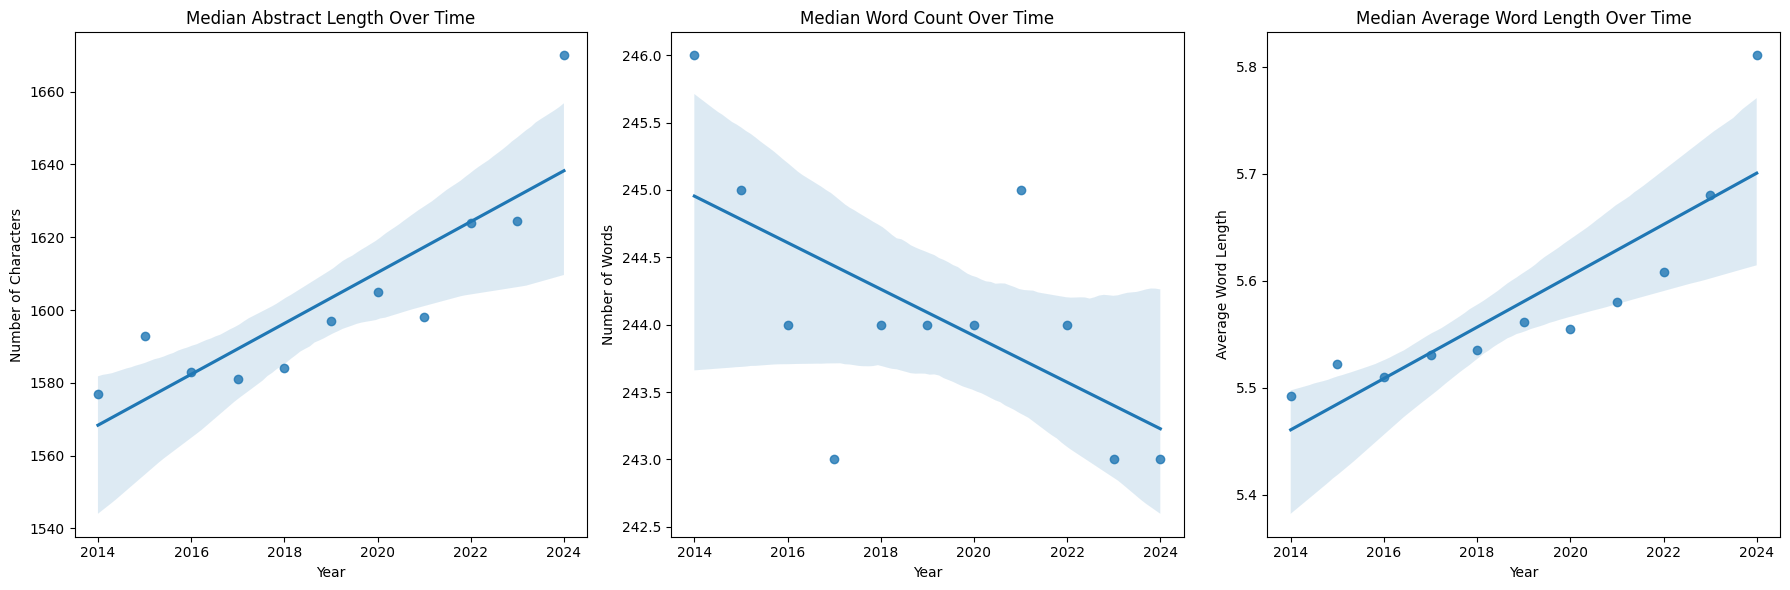

In [11]:
# %%
plot_complexity_over_time(df)

 Finally, let's look at the most common words in the abstracts to get an initial sense of the content.

In [12]:
# %%
def plot_common_words(df: pd.DataFrame, n_words: int = 20) -> None:
    """
    Plot the most common words in the abstracts.

    Args:
        df (pd.DataFrame): The dataset containing abstracts
        n_words (int): Number of top words to display
    """
    stop_words = set(stopwords.words("english"))
    words = " ".join(df["Abstract"]).lower().split()
    word_freq = Counter(
        word for word in words if word not in stop_words and len(word) > 2
    )

    top_words = dict(word_freq.most_common(n_words))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(top_words.keys()), y=list(top_words.values()))
    plt.title(f"Top {n_words} Most Common Words in Abstracts")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

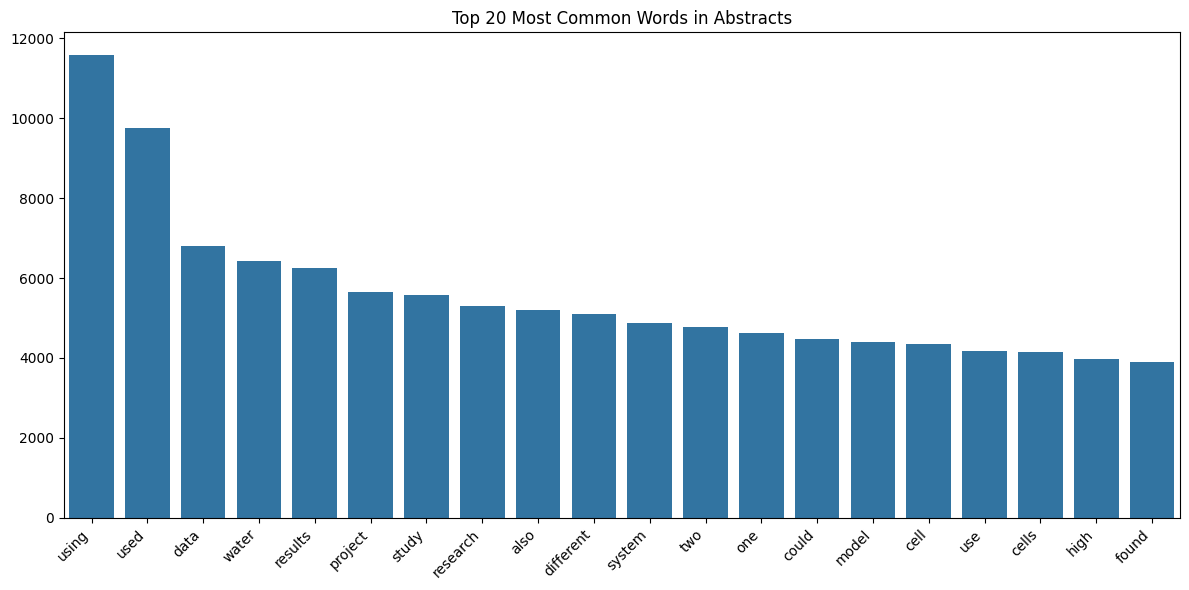

In [13]:
# %%
plot_common_words(df)

 This concludes our initial Exploratory Data Analysis. We've gained insights into the distribution of projects across various dimensions and analyzed the complexity of the abstracts. These findings will inform our subsequent text preprocessing and topic modeling steps.

 ## 4. Data Preprocessing

 Data preprocessing is a crucial step in our analysis pipeline. We'll clean the text, tokenize it, remove stopwords, and apply lemmatization. We'll also handle domain-specific terms and acronyms common in scientific writing.

 First, let's define a function to clean and tokenize the text:

In [14]:
# %%
def clean_text(text: str) -> str:
    """
    Clean the input text by removing special characters and extra whitespace.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

 Next, we'll create a custom stopword list that includes common scientific terms we don't want to remove:

In [15]:
# %%
def get_custom_stopwords() -> List[str]:
    """
    Create a custom stopword list that excludes important scientific terms.

    Returns:
        List[str]: Custom stopword list
    """
    custom_stopwords = set(stopwords.words("english"))
    # Remove important scientific terms from stopwords
    words_to_keep = {"no", "not", "only", "very", "significant", "significantly"}
    custom_stopwords = custom_stopwords - words_to_keep
    return list(custom_stopwords)


custom_stopwords = get_custom_stopwords()

 Now, let's create a function to handle domain-specific terms and acronyms:

In [16]:
# %%
def handle_domain_specific_terms(tokens: List[str]) -> List[str]:
    """
    Handle domain-specific terms and acronyms.

    Args:
        tokens (List[str]): List of tokens

    Returns:
        List[str]: Processed list of tokens
    """
    # Dictionary of domain-specific terms and their replacements
    domain_terms = {
        "dna": "deoxyribonucleic_acid",
        "rna": "ribonucleic_acid",
        "ai": "artificial_intelligence",
        "ml": "machine_learning",
        # Add more domain-specific terms as needed
    }

    return [domain_terms.get(token, token) for token in tokens]

 Let's create our main preprocessing function:

In [17]:
# %%
def preprocess_text(text: str, lemmatizer: WordNetLemmatizer) -> List[str]:
    """
    Preprocess the input text by cleaning, tokenizing, removing stopwords, and lemmatizing.

    Args:
        text (str): Input text
        lemmatizer (WordNetLemmatizer): NLTK's WordNetLemmatizer instance

    Returns:
        List[str]: List of preprocessed tokens
    """
    # Clean the text
    cleaned_text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(cleaned_text)

    # Remove stopwords and short tokens
    tokens = [
        token for token in tokens if token not in custom_stopwords and len(token) > 2
    ]

    # Handle domain-specific terms
    tokens = handle_domain_specific_terms(tokens)

    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

 Now, let's apply our preprocessing to the abstracts:

In [18]:
# %%
def preprocess_abstracts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess all abstracts in the dataframe.

    Args:
        df (pd.DataFrame): Input dataframe with 'Abstract' column

    Returns:
        pd.DataFrame: Dataframe with added 'Preprocessed_Abstract' column
    """
    lemmatizer = WordNetLemmatizer()
    tqdm.pandas(desc="Preprocessing abstracts")
    df["Preprocessed_Abstract"] = df["Abstract"].progress_apply(
        lambda x: preprocess_text(x, lemmatizer)
    )
    return df

In [19]:
# %%
df = preprocess_abstracts(df)
df["Preprocessed_Abstract"].head()

Preprocessing abstracts: 100%|██████████| 14871/14871 [00:25<00:00, 579.55it/s]


0    [purpose, human, neck, replica, made, simulate...
1    [purpose, experiment, determine, different, fa...
2    [organochlorine, pesticide, agriculture, not, ...
3    [purpose, project, determine, ecofriendly, gro...
4    [study, comparing, mineral, nutrition, hydropo...
Name: Preprocessed_Abstract, dtype: object

 Let's examine the effect of our preprocessing:

In [20]:
# %%
def compare_preprocessing(df: pd.DataFrame, n_samples: int = 5) -> None:
    """
    Compare original and preprocessed abstracts.

    Args:
        df (pd.DataFrame): Dataframe with 'Abstract' and 'Preprocessed_Abstract' columns
        n_samples (int): Number of samples to display
    """
    samples = df.sample(n_samples)
    for _, row in samples.iterrows():
        print("Original:", row["Abstract"][:100], "...")
        print("Preprocessed:", " ".join(row["Preprocessed_Abstract"][:20]), "...")
        print()

In [21]:
# %%
compare_preprocessing(df)

Original: Expanding the applications of Unmanned Aerial Vehicles (UAVs) requires overcoming limitations in fli ...
Preprocessed: expanding application unmanned aerial vehicle uavs requires overcoming limitation flight endurance imposed current battery energy density adverse weather condition like ...

Original: Silicon Nitride is becoming a significant building material in many microelectronic, medical-imaging ...
Preprocessed: silicon nitride becoming significant building material many microelectronic medicalimaging device automotive part superconductive mechanical property however investigation typically heated pressurized ...

Original: The aim of this research is to detect tumor tissue during brain surgery using data preprocessing and ...
Preprocessed: aim research detect tumor tissue brain surgery using data preprocessing machine learning brain tumor leading cause cancerrelated death child united ...

Original: Anthracnose disease, caused by Colletotrichum gloeosporioides, is amon

 ## 5. Feature Engineering

 In this section, we'll create document-term matrices using different vectorization techniques and compare their effectiveness.

 First, let's create a function to prepare our corpus:

In [22]:
# %%
def prepare_corpus(df: pd.DataFrame) -> List[str]:
    """
    Prepare the corpus for vectorization.

    Args:
        df (pd.DataFrame): Dataframe with 'Preprocessed_Abstract' column

    Returns:
        List[str]: List of preprocessed abstracts as strings
    """
    return [" ".join(abstract) for abstract in df["Preprocessed_Abstract"]]

In [23]:
# %%
corpus = prepare_corpus(df)

 Now, let's create functions for different vectorization techniques:

In [24]:
# %%
def create_bow_matrix(corpus: List[str]) -> Tuple[np.ndarray, List[str]]:
    """
    Create a Bag-of-Words matrix.

    Args:
        corpus (List[str]): List of preprocessed abstracts

    Returns:
        Tuple[np.ndarray, List[str]]: BoW matrix and feature names
    """
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(corpus)
    return bow_matrix, vectorizer.get_feature_names_out()


def create_tfidf_matrix(corpus: List[str]) -> Tuple[np.ndarray, List[str]]:
    """
    Create a TF-IDF matrix.

    Args:
        corpus (List[str]): List of preprocessed abstracts

    Returns:
        Tuple[np.ndarray, List[str]]: TF-IDF matrix and feature names
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    return tfidf_matrix, vectorizer.get_feature_names_out()

In [25]:
# %%
bow_matrix, bow_features = create_bow_matrix(corpus)
tfidf_matrix, tfidf_features = create_tfidf_matrix(corpus)

print("BoW matrix shape:", bow_matrix.shape)
print("TF-IDF matrix shape:", tfidf_matrix.shape)

BoW matrix shape: (14871, 73655)
TF-IDF matrix shape: (14871, 73655)


 Let's compare the most frequent terms in both representations:

In [26]:
# %%
def print_top_terms(
    matrix: np.ndarray,
    feature_names: List[str],
    top_n: int = 20,
) -> None:
    """
    Print the top terms based on their frequency in the matrix.

    Args:
        matrix (np.ndarray): Document-term matrix
        feature_names (List[str]): List of feature names
        top_n (int): Number of top terms to display
    """
    sums = matrix.sum(axis=0).A1
    top_term_indices = sums.argsort()[-top_n:][::-1]
    top_terms = [(feature_names[i], sums[i]) for i in top_term_indices]

    print(f"Top {top_n} terms:")
    for term, count in top_terms:
        print(f"{term}: {count:.2f}")

In [27]:
# %%
print("Top terms in BoW representation:")
print_top_terms(bow_matrix, bow_features)
print("\nTop terms in TF-IDF representation:")
print_top_terms(tfidf_matrix, tfidf_features)

Top terms in BoW representation:
Top 20 terms:
using: 11638.00
cell: 10867.00
used: 10395.00
result: 8982.00
study: 8561.00
water: 8283.00
data: 8256.00
system: 8237.00
model: 7363.00
project: 6887.00
method: 6765.00
not: 6662.00
research: 6333.00
test: 6226.00
time: 5701.00
also: 5604.00
effect: 5379.00
one: 5211.00
different: 5160.00
two: 4910.00

Top terms in TF-IDF representation:
Top 20 terms:
cell: 293.64
water: 249.65
system: 226.29
using: 218.11
model: 209.07
used: 201.77
data: 199.13
study: 180.47
result: 175.69
method: 173.23
project: 166.46
test: 161.36
cancer: 160.25
device: 154.93
energy: 153.32
research: 150.72
not: 150.08
plant: 148.94
time: 148.04
effect: 137.82


 Finally, let's create a function to convert our matrix to the format required by gensim for LDA:

In [28]:
# %%
def matrix_to_gensim_corpus(
    matrix: np.ndarray,
    feature_names: List[str],
) -> Tuple[
    List[List[Tuple[int, float]]],
    Dict[str, int],
]:
    """
    Convert a document-term matrix to gensim corpus format.

    Args:
        matrix (np.ndarray): Document-term matrix
        feature_names (List[str]): List of feature names

    Returns:
        Tuple[List[List[Tuple[int, float]]], Dict[str, int]]: Gensim corpus and dictionary
    """
    corpus = [
        [(i, float(count)) for i, count in enumerate(doc) if count != 0]
        for doc in matrix.A
    ]
    id2word = {i: word for i, word in enumerate(feature_names)}
    return corpus, id2word

In [29]:
# %%
gensim_corpus, id2word = matrix_to_gensim_corpus(tfidf_matrix, tfidf_features)
print("Number of documents in gensim corpus:", len(gensim_corpus))
print("Number of unique terms:", len(id2word))

Number of documents in gensim corpus: 14871
Number of unique terms: 73655


 We've now completed our data preprocessing and feature engineering steps. We've cleaned and tokenized the text, handled domain-specific terms, and created document-term matrices using both Bag-of-Words and TF-IDF representations. In the next section, we'll use these prepared features to train our LDA model for topic modeling.

 ## 6. Topic Modeling

 In this section, we'll use Latent Dirichlet Allocation (LDA) to perform topic modeling on our preprocessed ISEF abstracts. We'll determine the optimal number of topics, train the LDA model, and evaluate its quality.

 First, let's create a gensim Dictionary and corpus:

In [30]:
# %%
def create_gensim_dict_and_corpus(
    texts: List[List[str]],
) -> Tuple[
    Dictionary,
    List[List[Tuple[int, int]]],
]:
    """
    Create a gensim Dictionary and corpus from the preprocessed texts.

    Args:
        texts (List[List[str]]): List of tokenized texts

    Returns:
        Tuple[Dictionary, List[List[Tuple[int, int]]]]: Gensim Dictionary and corpus
    """
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

In [31]:
# %%
texts = df["Preprocessed_Abstract"].tolist()
dictionary, corpus = create_gensim_dict_and_corpus(texts)
print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")

2024-07-23 03:00:20,793 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2024-07-23 03:00:21,726 - INFO - adding document #10000 to Dictionary<57614 unique tokens: ['acquisition', 'affect', 'amplified', 'analysis', 'anova']...>
2024-07-23 03:00:22,243 - INFO - built Dictionary<73662 unique tokens: ['acquisition', 'affect', 'amplified', 'analysis', 'anova']...> from 14871 documents (total 2036909 corpus positions)
2024-07-23 03:00:22,244 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<73662 unique tokens: ['acquisition', 'affect', 'amplified', 'analysis', 'anova']...> from 14871 documents (total 2036909 corpus positions)", 'datetime': '2024-07-23T03:00:22.244262', 'gensim': '4.3.3', 'python': '3.10.13 (main, Jul 11 2024, 16:23:02) [GCC 9.4.0]', 'platform': 'Linux-6.5.0-1022-azure-x86_64-with-glibc2.31', 'event': 'created'}


Number of unique tokens: 73662
Number of documents: 14871


 Now, let's create a function to compute model coherence for different numbers of topics:

In [32]:
# %%
def compute_coherence_values(
    corpus: List[List[Tuple[int, int]]],
    dictionary: Dictionary,
    texts: List[List[str]],
    start: int = 5,
    limit: int = 50,
    step: int = 5,
) -> Tuple[List[int], List[float]]:
    """
    Compute coherence values for LDA models with different numbers of topics.

    Args:
        corpus (List[List[Tuple[int, int]]]): Gensim corpus
        dictionary (Dictionary): Gensim dictionary
        texts (List[List[str]]): List of tokenized texts
        start (int): Starting number of topics
        limit (int): Maximum number of topics
        step (int): Step size for iterating through number of topics

    Returns:
        Tuple[List[int], List[float]]: Lists of number of topics and corresponding coherence values
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(
        range(start, limit, step), desc="Computing coherence values"
    ):
        model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            passes=10,
            workers=4,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v",
        )
        coherence_values.append(coherencemodel.get_coherence())

    return range(start, limit, step), coherence_values

 Now, let's compute coherence values for different numbers of topics:

In [33]:
# %%
topic_range, coherence_values = compute_coherence_values(
    corpus=corpus,
    dictionary=dictionary,
    texts=texts,
)

Computing coherence values:   0%|          | 0/9 [00:00<?, ?it/s]2024-07-23 03:00:23,264 - INFO - using symmetric alpha at 0.2
2024-07-23 03:00:23,264 - INFO - using symmetric eta at 0.2
2024-07-23 03:00:23,272 - INFO - using serial LDA version on this node
2024-07-23 03:00:23,296 - INFO - running online LDA training, 5 topics, 10 passes over the supplied corpus of 14871 documents, updating every 8000 documents, evaluating every ~14871 documents, iterating 50x with a convergence threshold of 0.001000
2024-07-23 03:00:23,298 - INFO - training LDA model using 4 processes
2024-07-23 03:00:23,363 - INFO - PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/14871, outstanding queue size 1
2024-07-23 03:00:23,410 - INFO - PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/14871, outstanding queue size 2
2024-07-23 03:00:23,413 - INFO - PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/14871, outstanding queue size 3
2024-07-23 03:00:23,415 - INFO - PROGRESS: 

 Let's visualize the coherence scores to determine the optimal number of topics:

In [34]:
# %%
def plot_coherence_values(
    topic_range: List[int],
    coherence_values: List[float],
) -> None:
    """
    Plot coherence values for different numbers of topics.

    Args:
        topic_range (List[int]): List of number of topics
        coherence_values (List[float]): Corresponding coherence values
    """
    plt.figure(figsize=(12, 6))
    plt.plot(topic_range, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Topic Coherence Scores")
    plt.show()

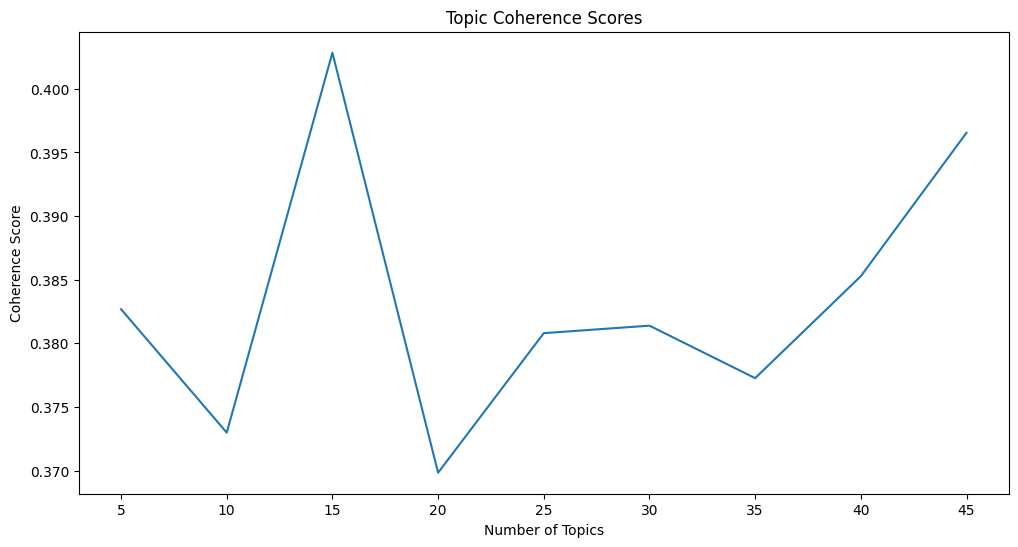

In [35]:
# %%
plot_coherence_values(topic_range, coherence_values)

 Based on the coherence scores, let's select the optimal number of topics and train our final LDA model:

In [36]:
# %%
def train_lda_model(
    corpus: List[List[Tuple[int, int]]], dictionary: Dictionary, num_topics: int
) -> LdaMulticore:
    """
    Train the LDA model with the specified number of topics.

    Args:
        corpus (List[List[Tuple[int, int]]]): Gensim corpus
        dictionary (Dictionary): Gensim dictionary
        num_topics (int): Number of topics for the LDA model

    Returns:
        LdaMulticore: Trained LDA model
    """
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=100,
        passes=10,
        per_word_topics=True,
        workers=4,
    )
    return lda_model

In [37]:
# %%
optimal_num_topics = 15

# Train the final LDA model
lda_model = train_lda_model(corpus, dictionary, optimal_num_topics)

2024-07-23 03:10:48,519 - INFO - using symmetric alpha at 0.06666666666666667
2024-07-23 03:10:48,520 - INFO - using symmetric eta at 0.06666666666666667
2024-07-23 03:10:48,528 - INFO - using serial LDA version on this node
2024-07-23 03:10:48,603 - INFO - running online LDA training, 15 topics, 10 passes over the supplied corpus of 14871 documents, updating every 400 documents, evaluating every ~4000 documents, iterating 50x with a convergence threshold of 0.001000
2024-07-23 03:10:48,605 - INFO - training LDA model using 4 processes
2024-07-23 03:10:48,686 - INFO - PROGRESS: pass 0, dispatched chunk #0 = documents up to #100/14871, outstanding queue size 1
2024-07-23 03:10:48,698 - INFO - PROGRESS: pass 0, dispatched chunk #1 = documents up to #200/14871, outstanding queue size 2
2024-07-23 03:10:48,699 - INFO - PROGRESS: pass 0, dispatched chunk #2 = documents up to #300/14871, outstanding queue size 3
2024-07-23 03:10:48,700 - INFO - PROGRESS: pass 0, dispatched chunk #3 = documen

 Now that we have our trained LDA model, let's examine the topics it has discovered:

In [38]:
# %%
def print_topics(lda_model: LdaMulticore, num_words: int = 10) -> None:
    """
    Print the topics discovered by the LDA model.

    Args:
        lda_model (LdaMulticore): Trained LDA model
        num_words (int): Number of top words to display for each topic
    """
    for idx, topic in lda_model.print_topics(-1, num_words):
        print(f"Topic {idx}: {topic}")

In [39]:
# %%
print_topics(lda_model)

2024-07-23 03:12:26,789 - INFO - topic #0 (0.067): 0.033*"water" + 0.008*"sample" + 0.007*"used" + 0.007*"level" + 0.006*"using" + 0.006*"oil" + 0.005*"environment" + 0.005*"concentration" + 0.005*"result" + 0.005*"solution"
2024-07-23 03:12:26,790 - INFO - topic #1 (0.067): 0.011*"design" + 0.009*"force" + 0.009*"speed" + 0.007*"wind" + 0.007*"angle" + 0.007*"experiment" + 0.006*"flow" + 0.006*"wave" + 0.006*"pressure" + 0.006*"motor"
2024-07-23 03:12:26,791 - INFO - topic #2 (0.067): 0.038*"energy" + 0.017*"power" + 0.017*"solar" + 0.015*"light" + 0.012*"temperature" + 0.012*"system" + 0.012*"cell" + 0.011*"efficiency" + 0.010*"device" + 0.010*"fuel"
2024-07-23 03:12:26,793 - INFO - topic #3 (0.067): 0.013*"material" + 0.009*"using" + 0.009*"surface" + 0.008*"method" + 0.008*"property" + 0.007*"high" + 0.007*"used" + 0.006*"application" + 0.006*"nanoparticles" + 0.006*"structure"
2024-07-23 03:12:26,794 - INFO - topic #4 (0.067): 0.017*"acid" + 0.015*"concentration" + 0.013*"hydrogen

Topic 0: 0.033*"water" + 0.008*"sample" + 0.007*"used" + 0.007*"level" + 0.006*"using" + 0.006*"oil" + 0.005*"environment" + 0.005*"concentration" + 0.005*"result" + 0.005*"solution"
Topic 1: 0.011*"design" + 0.009*"force" + 0.009*"speed" + 0.007*"wind" + 0.007*"angle" + 0.007*"experiment" + 0.006*"flow" + 0.006*"wave" + 0.006*"pressure" + 0.006*"motor"
Topic 2: 0.038*"energy" + 0.017*"power" + 0.017*"solar" + 0.015*"light" + 0.012*"temperature" + 0.012*"system" + 0.012*"cell" + 0.011*"efficiency" + 0.010*"device" + 0.010*"fuel"
Topic 3: 0.013*"material" + 0.009*"using" + 0.009*"surface" + 0.008*"method" + 0.008*"property" + 0.007*"high" + 0.007*"used" + 0.006*"application" + 0.006*"nanoparticles" + 0.006*"structure"
Topic 4: 0.017*"acid" + 0.015*"concentration" + 0.013*"hydrogen" + 0.012*"solution" + 0.011*"fly" + 0.010*"glucose" + 0.010*"production" + 0.010*"reaction" + 0.008*"catalyst" + 0.008*"ethanol"
Topic 5: 0.046*"cell" + 0.024*"cancer" + 0.017*"gene" + 0.017*"protein" + 0.011*

 Let's evaluate the quality of our model using perplexity and coherence scores:

In [40]:
# %%
def evaluate_lda_model(
    lda_model: LdaMulticore,
    corpus: List[List[Tuple[int, int]]],
    texts: List[List[str]],
    dictionary: Dictionary,
) -> Tuple[float, float]:
    """
    Evaluate the LDA model using perplexity and coherence scores.

    Args:
        lda_model (LdaMulticore): Trained LDA model
        corpus (List[List[Tuple[int, int]]]): Gensim corpus
        texts (List[List[str]]): List of tokenized texts
        dictionary (Dictionary): Gensim dictionary

    Returns:
        Tuple[float, float]: Perplexity and coherence scores
    """
    perplexity = lda_model.log_perplexity(corpus)
    coherence_model = CoherenceModel(
        model=lda_model, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence_score = coherence_model.get_coherence()
    return perplexity, coherence_score

In [41]:
# %%
perplexity, coherence_score = evaluate_lda_model(lda_model, corpus, texts, dictionary)
print(f"Perplexity: {perplexity}")
print(f"Coherence Score: {coherence_score}")

2024-07-23 03:12:58,909 - INFO - -9.826 per-word bound, 907.8 perplexity estimate based on a held-out corpus of 14871 documents with 2036909 words
2024-07-23 03:12:58,922 - INFO - using ParallelWordOccurrenceAccumulator<processes=3, batch_size=64> to estimate probabilities from sliding windows
2024-07-23 03:12:58,985 - INFO - 1 batches submitted to accumulate stats from 64 documents (1654 virtual)
2024-07-23 03:12:58,991 - INFO - 2 batches submitted to accumulate stats from 128 documents (3169 virtual)
2024-07-23 03:12:58,996 - INFO - 3 batches submitted to accumulate stats from 192 documents (5136 virtual)
2024-07-23 03:12:59,000 - INFO - 4 batches submitted to accumulate stats from 256 documents (6664 virtual)
2024-07-23 03:12:59,004 - INFO - 5 batches submitted to accumulate stats from 320 documents (8222 virtual)
2024-07-23 03:12:59,009 - INFO - 6 batches submitted to accumulate stats from 384 documents (10070 virtual)
2024-07-23 03:12:59,100 - INFO - 7 batches submitted to accumul

Perplexity: -9.826228916751456
Coherence Score: 0.4728027660756035


 Now, let's visualize the topics using pyLDAvis:

In [43]:
# %%
def visualize_lda_topics(
    lda_model: LdaMulticore,
    corpus: List[List[Tuple[int, int]]],
    dictionary: Dictionary,
) -> None:
    """
    Visualize LDA topics using pyLDAvis.

    Args:
        lda_model (LdaMulticore): Trained LDA model
        corpus (List[List[Tuple[int, int]]]): Gensim corpus
        dictionary (Dictionary): Gensim dictionary
    """
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis, "../data/lda_visualization.html")
    return vis

In [44]:
# %%
vis = visualize_lda_topics(lda_model, corpus, dictionary)
print("LDA visualization saved as 'lda_visualization.html'")

LDA visualization saved as 'lda_visualization.html'


 Finally, let's assign topics to each document in our dataset:

In [45]:
# %%
def assign_topics_to_documents(
    lda_model: LdaMulticore,
    corpus: List[List[Tuple[int, int]]],
) -> List[int]:
    """
    Assign the most probable topic to each document.

    Args:
        lda_model (LdaMulticore): Trained LDA model
        corpus (List[List[Tuple[int, int]]]): Gensim corpus

    Returns:
        List[int]: List of assigned topic indices for each document
    """
    topic_assignments = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        most_probable_topic = max(topic_dist, key=lambda x: x[1])[0]
        topic_assignments.append(most_probable_topic)
    return topic_assignments

In [46]:
# %%
df["Assigned_Topic"] = assign_topics_to_documents(lda_model, corpus)
df[["Project Title", "Assigned_Topic"]].head(10)

,Project Title,Assigned_Topic
0,Dynamic Response of a Human Neck Replica to Ax...,1
1,The Effect of Nutrient Solution Concentration ...,11
2,Do Air Root Pruning Pots Accelerate Success in...,14
3,Insect-repelling Plants & New Organic Pesticide,14
4,How Do Different Factors Affect the Accuracy o...,14
5,Dye Sensitized Solar Cells: New Structures and...,2
6,A Novel Method for Determination of Camera Pos...,13
7,Observational Detection of Solar g-mode Oscill...,13
8,Synthesis of Periodic Mesoporous Organosilicas...,5
9,A Novel Mathematical Simulation to Study the D...,3


In [48]:
df.to_csv("../data/isef_projects_with_topic_labels.csv")

 We have now completed our topic modeling process. We've determined the optimal number of topics, trained an LDA model, evaluated its quality, visualized the topics, and assigned topics to each document in our dataset. In the next section, we'll analyze the results and derive insights from our topic model.

 ## 7. Results Analysis and Visualization

 In this section, we'll analyze the results of our topic modeling and create visualizations to gain insights into the ISEF project abstracts.

 First, let's create a function to get the top words for each topic:

In [50]:
# %%
def get_top_words_per_topic(
    lda_model: LdaMulticore,
    n_words: int = 10,
) -> Dict[int, List[Tuple[str, float]]]:
    """
    Get the top words for each topic in the LDA model.

    Args:
        lda_model (LdaMulticore): Trained LDA model
        n_words (int): Number of top words to retrieve for each topic

    Returns:
        Dict[int, List[Tuple[str, float]]]: Dictionary mapping topic IDs to lists of (word, probability) tuples
    """
    top_words = {}
    for idx, topic in lda_model.print_topics(-1, n_words):
        top_words[idx] = [
            (word.split("*")[1].strip().replace('"', ""), float(word.split("*")[0]))
            for word in topic.split(" + ")
        ]
    return top_words

In [51]:
# %%
top_words = get_top_words_per_topic(lda_model)

2024-07-23 03:25:04,247 - INFO - topic #0 (0.067): 0.033*"water" + 0.008*"sample" + 0.007*"used" + 0.007*"level" + 0.006*"using" + 0.006*"oil" + 0.005*"environment" + 0.005*"concentration" + 0.005*"result" + 0.005*"solution"
2024-07-23 03:25:04,249 - INFO - topic #1 (0.067): 0.011*"design" + 0.009*"force" + 0.009*"speed" + 0.007*"wind" + 0.007*"angle" + 0.007*"experiment" + 0.006*"flow" + 0.006*"wave" + 0.006*"pressure" + 0.006*"motor"
2024-07-23 03:25:04,251 - INFO - topic #2 (0.067): 0.038*"energy" + 0.017*"power" + 0.017*"solar" + 0.015*"light" + 0.012*"temperature" + 0.012*"system" + 0.012*"cell" + 0.011*"efficiency" + 0.010*"device" + 0.010*"fuel"
2024-07-23 03:25:04,252 - INFO - topic #3 (0.067): 0.013*"material" + 0.009*"using" + 0.009*"surface" + 0.008*"method" + 0.008*"property" + 0.007*"high" + 0.007*"used" + 0.006*"application" + 0.006*"nanoparticles" + 0.006*"structure"
2024-07-23 03:25:04,254 - INFO - topic #4 (0.067): 0.017*"acid" + 0.015*"concentration" + 0.013*"hydrogen

 Now, let's create word clouds for each topic:

In [52]:
# %%
def create_topic_wordclouds(
    top_words: Dict[int, List[Tuple[str, float]]],
    n_cols: int = 5,
) -> None:
    """
    Create and display word clouds for each topic.

    Args:
        top_words (Dict[int, List[Tuple[str, float]]]): Dictionary of top words per topic
        n_cols (int): Number of columns in the plot grid
    """
    n_topics = len(top_words)
    n_rows = (n_topics - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, (topic_id, words) in enumerate(top_words.items()):
        word_dict = dict(words)
        wordcloud = WordCloud(
            width=400, height=300, background_color="white"
        ).generate_from_frequencies(word_dict)

        ax = axes[i]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}")
        ax.axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

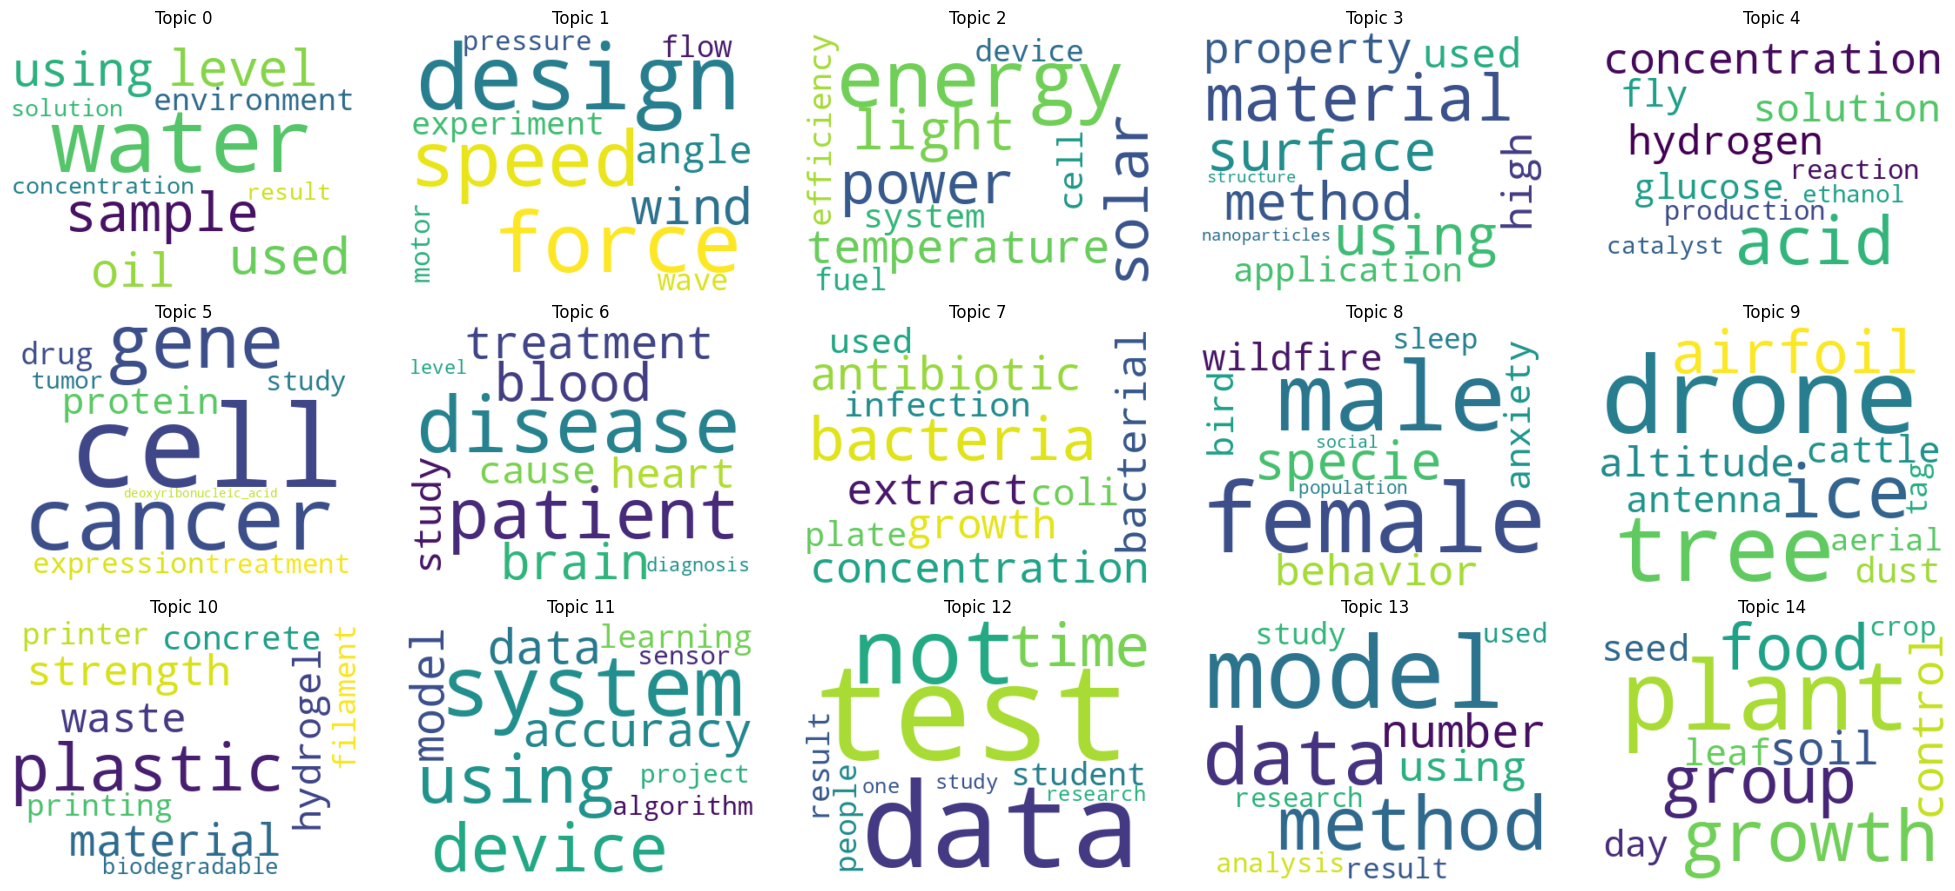

In [53]:
# %%
create_topic_wordclouds(top_words)

 Let's analyze the distribution of topics across the dataset:

In [54]:
# %%
def plot_topic_distribution(df: pd.DataFrame) -> None:
    """
    Plot the distribution of topics across the dataset.

    Args:
        df (pd.DataFrame): DataFrame containing the assigned topics
    """
    topic_counts = df["Assigned_Topic"].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values)
    plt.title("Distribution of Topics Across the Dataset")
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Documents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

2024-07-23 03:26:18,025 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-23 03:26:18,032 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


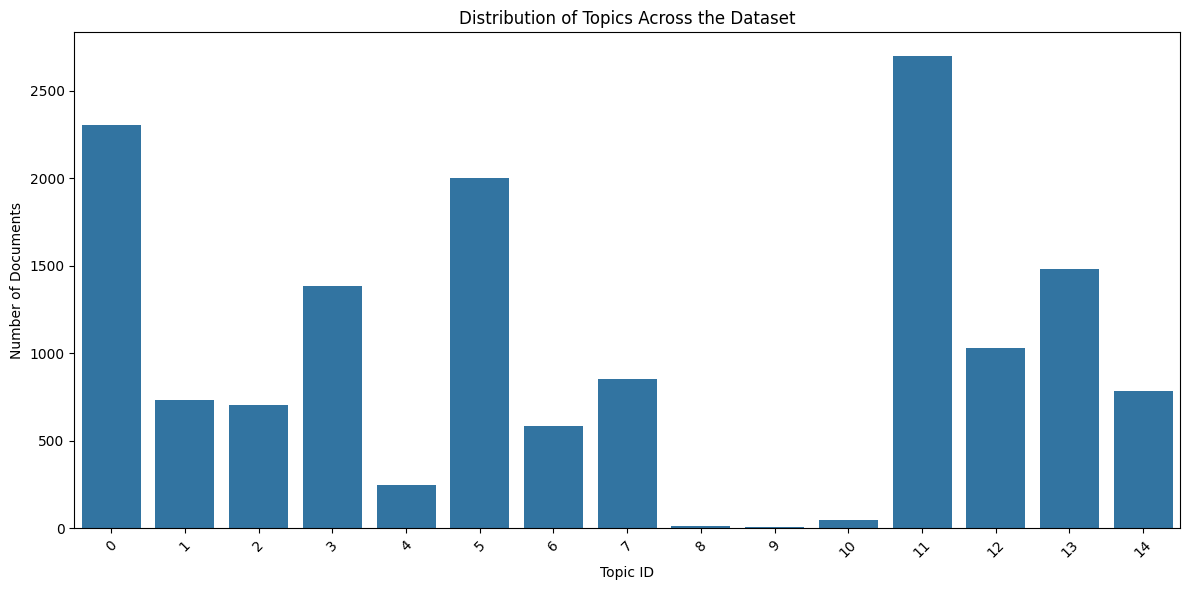

In [55]:
# %%
plot_topic_distribution(df)

 Now, let's analyze how the topics have evolved over time:

In [56]:
# %%
def plot_topic_trends(df: pd.DataFrame, n_topics: int) -> None:
    """
    Plot the trends of topics over time.

    Args:
        df (pd.DataFrame): DataFrame containing the assigned topics and years
        n_topics (int): Number of topics in the LDA model
    """
    topic_year_counts = (
        df.groupby(["Year", "Assigned_Topic"]).size().unstack(fill_value=0)
    )
    topic_year_proportions = topic_year_counts.div(
        topic_year_counts.sum(axis=1), axis=0
    )

    plt.figure(figsize=(12, 6))
    for topic in range(n_topics):
        plt.plot(
            topic_year_proportions.index,
            topic_year_proportions[topic],
            label=f"Topic {topic}",
        )

    plt.title("Topic Trends Over Time")
    plt.xlabel("Year")
    plt.ylabel("Proportion of Documents")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

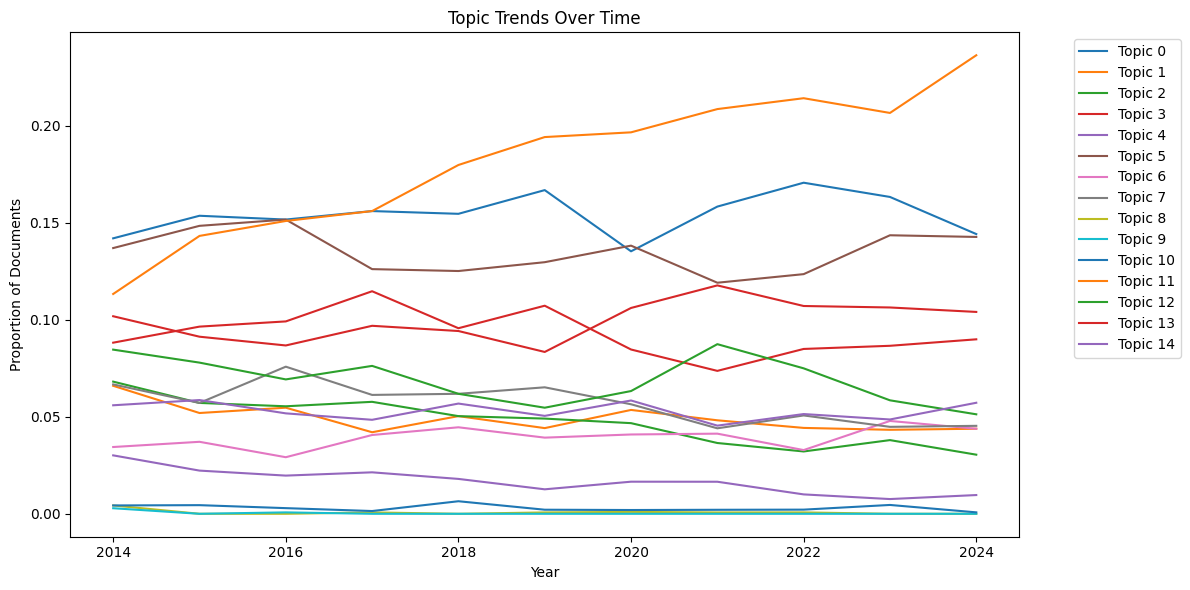

In [57]:
# %%
plot_topic_trends(df, optimal_num_topics)

 Let's analyze the relationship between topics and project categories:

In [58]:
# %%
def plot_topic_category_heatmap(df: pd.DataFrame, n_topics: int) -> None:
    """
    Plot a heatmap showing the relationship between topics and project categories.

    Args:
        df (pd.DataFrame): DataFrame containing the assigned topics and categories
        n_topics (int): Number of topics in the LDA model
    """
    topic_category_counts = (
        df.groupby(["Category", "Assigned_Topic"]).size().unstack(fill_value=0)
    )
    topic_category_proportions = topic_category_counts.div(
        topic_category_counts.sum(axis=1), axis=0
    )

    plt.figure(figsize=(15, 10))
    sns.heatmap(topic_category_proportions, annot=True, fmt=".2f", cmap="YlOrRd")
    plt.title("Topic Distribution Across Project Categories")
    plt.xlabel("Topic ID")
    plt.ylabel("Project Category")
    plt.tight_layout()
    plt.show()

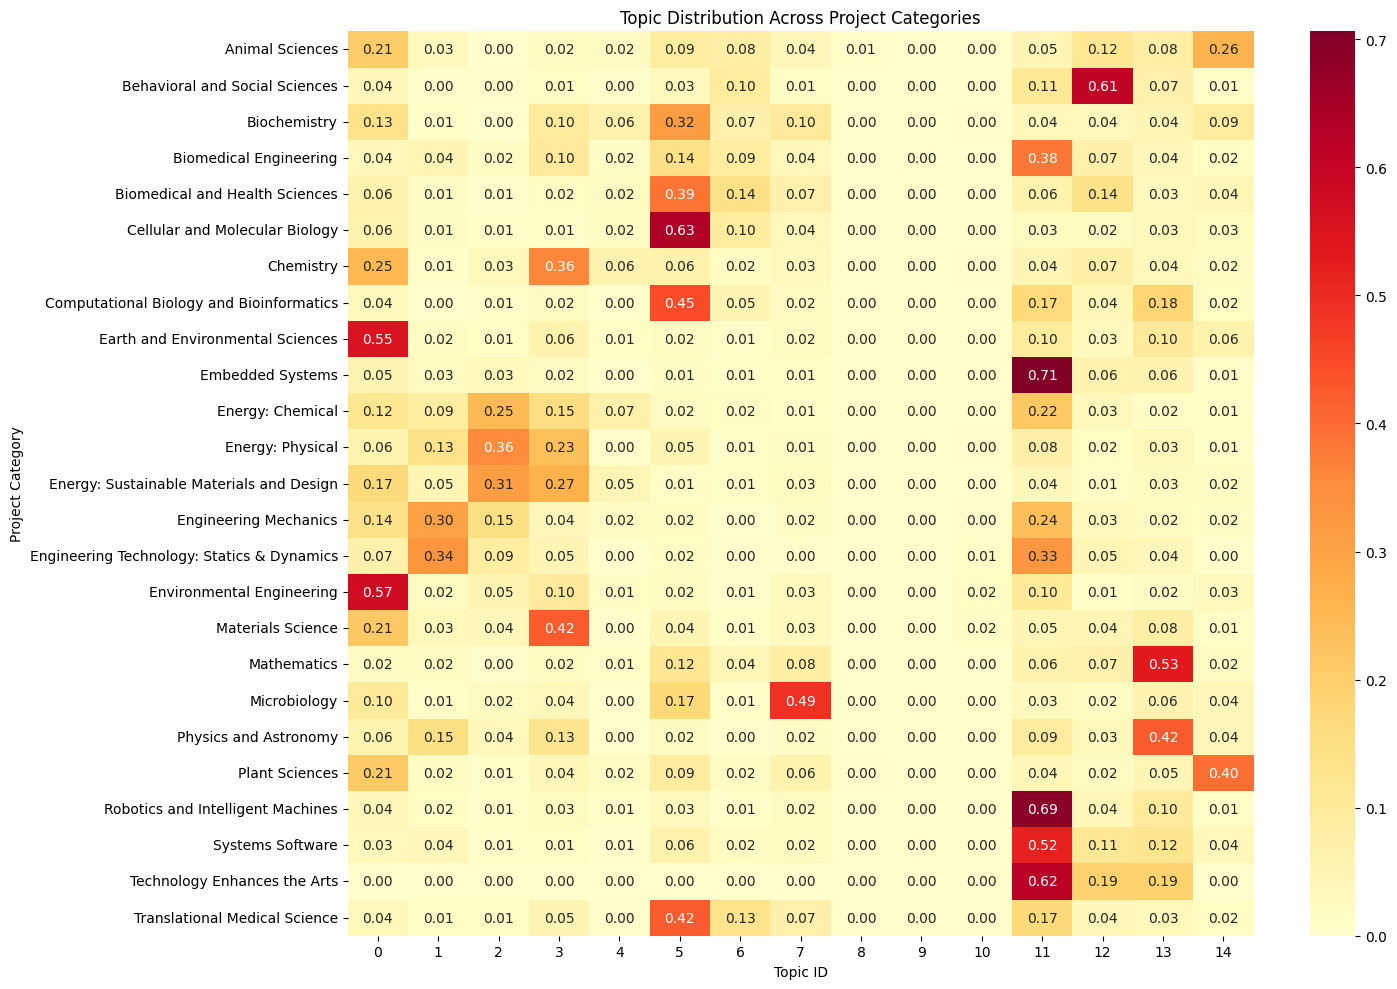

In [59]:
# %%
plot_topic_category_heatmap(df, optimal_num_topics)

 Now, let's identify the most representative documents for each topic:

In [60]:
# %%
def get_representative_docs(
    lda_model: LdaMulticore,
    corpus: List[List[Tuple[int, int]]],
    df: pd.DataFrame,
    n_docs: int = 5,
) -> Dict[int, List[str]]:
    """
    Get the most representative documents for each topic.

    Args:
        lda_model (LdaMulticore): Trained LDA model
        corpus (List[List[Tuple[int, int]]]): Gensim corpus
        df (pd.DataFrame): DataFrame containing the original abstracts
        n_docs (int): Number of representative documents to retrieve for each topic

    Returns:
        Dict[int, List[str]]: Dictionary mapping topic IDs to lists of representative document titles
    """
    rep_docs = {topic: [] for topic in range(lda_model.num_topics)}

    for i, doc in enumerate(corpus):
        topic_probs = lda_model.get_document_topics(doc)
        for topic, prob in topic_probs:
            if len(rep_docs[topic]) < n_docs:
                rep_docs[topic].append((prob, df.iloc[i]["Project Title"]))
            else:
                min_prob = min(rep_docs[topic])[0]
                if prob > min_prob:
                    rep_docs[topic].remove(min(rep_docs[topic]))
                    rep_docs[topic].append((prob, df.iloc[i]["Project Title"]))
            rep_docs[topic] = sorted(rep_docs[topic], reverse=True)

    return {topic: [doc for _, doc in docs] for topic, docs in rep_docs.items()}

In [61]:
# %%
representative_docs = get_representative_docs(lda_model, corpus, df)

# Print representative documents for each topic
for topic, docs in representative_docs.items():
    print(f"Topic {topic}:")
    for doc in docs:
        print(f"  - {doc}")
    print()

Topic 0:
  - Using Lutjanus campechanus Scales as a Biosorbent to Filter Cu2+, Pb2+, and Cd2+ From Water
  - Algaenius
  - The Effect of Margaritifera margaritifera on Nitrates in Hastings NE
  - The Effect of Lemnaceae on Overall Water Quality Part ll: The Loss of Nitrate Nitrogen through Decomposition
  - Water Quality Analysis of the Gulpha Creek Watershed

Topic 1:
  - Blown Away: How Motor Speed Relates to Optimum Propeller Pitch
  - Aircraft Propeller Noise Reduction Using Owl Feather Inspired Notching
  - Foiled: Testing Lift and Drag on Airfoils in a Wind Tunnel
  - A Study of the Effects of Incomplete Spiroids on the Drag Coefficient of an Airfoil
  - Atomistic Simulation of Pathways for Mg2+-Water Dissociation with Rigorous Kinetics

Topic 2:
  - Compressed Air Energy Storage
  - Electromagnetic Energy Harvester to Power LEDs Illumination
  - Thermoelectric Generator
  - Improving the Harnessing of Solar Energy Using a Hybrid Photovoltaic Thermal System
  - Solar Powering Day

 Finally, let's create a function to summarize our findings:

In [62]:
# %%
def summarize_findings(
    df: pd.DataFrame,
    top_words: Dict[int, List[Tuple[str, float]]],
    representative_docs: Dict[int, List[str]],
) -> None:
    """
    Summarize the key findings from the topic modeling analysis.

    Args:
        df (pd.DataFrame): DataFrame containing the assigned topics and other metadata
        top_words (Dict[int, List[Tuple[str, float]]]): Dictionary of top words per topic
        representative_docs (Dict[int, List[str]]): Dictionary of representative documents per topic
    """
    print("Summary of Topic Modeling Findings:")
    print("===================================")

    # Number of topics
    print(f"Number of topics: {len(top_words)}")
    print()

    # Most common topics
    top_topics = df["Assigned_Topic"].value_counts().nlargest(3)
    print("Most common topics:")
    for topic, count in top_topics.items():
        print(f"  Topic {topic}: {count} documents")
        print(f"    Top words: {', '.join([word for word, _ in top_words[topic][:5]])}")
        print(f"    Example project: {representative_docs[topic][0]}")
    print()

    # Most diverse categories (categories with the most evenly distributed topics)
    category_topic_entropy = df.groupby("Category")["Assigned_Topic"].apply(
        lambda x: -np.sum(
            np.unique(x, return_counts=True)[1]
            / len(x)
            * np.log(np.unique(x, return_counts=True)[1] / len(x))
        )
    )
    diverse_categories = category_topic_entropy.nlargest(3)
    print("Most diverse categories (in terms of topic distribution):")
    for category, entropy in diverse_categories.items():
        print(f"  {category}: Entropy = {entropy:.2f}")
    print()

    # TODO: Topics with highest coherence
    # TODO: Topics showing the most change over time

In [63]:
# %%
summarize_findings(df, top_words, representative_docs)

Summary of Topic Modeling Findings:
Number of topics: 15

Most common topics:
  Topic 11: 2699 documents
    Top words: system, device, using, accuracy, data
    Example project: Cost-Effective Interactive Augmented Reality Table
  Topic 0: 2302 documents
    Top words: water, sample, used, level, using
    Example project: Using Lutjanus campechanus Scales as a Biosorbent to Filter Cu2+, Pb2+, and Cd2+ From Water
  Topic 5: 2004 documents
    Top words: cell, cancer, gene, protein, drug
    Example project: Combinations of Immune Checkpoint Blockade Inhibitors and Lymphodepletion as Immunotherapy for Myeloma

Most diverse categories (in terms of topic distribution):
  Animal Sciences: Entropy = 2.14
  Biochemistry: Entropy = 2.10
  Energy: Chemical: Entropy = 2.03



 This concludes our analysis and visualization of the topic modeling results. We've examined the distribution of topics, their trends over time, their relationship with project categories, and identified representative documents for each topic. These insights can help in understanding the main themes and trends in ISEF projects over the years.